# Fitting a segment of the light curve of V1298 Tau with Sequential Monte Carlo via PyMC3

First let's download the light curve using `lightkurve`:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import search_lightcurvefile

lcf = search_lightcurvefile('V1298 Tau', mission='K2').download_all()
lc = lcf.stitch()

//anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


In [2]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

(2230.0, 2260.0)

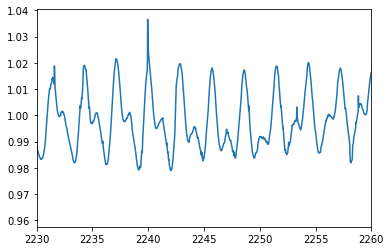

In [8]:
plt.plot(t, f)
plt.xlim([2230, 2260])
# plt.ylim([0.997, 1.003])

Next let's extract just a segment of the light curve that's quasiperiodic:

In [11]:
# max_time = 1090
# min_time = 1000
max_time = 2260
min_time = 2230
skip = 3

t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

<ErrorbarContainer object of 3 artists>

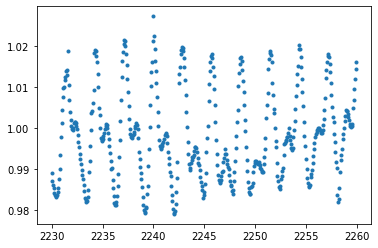

In [12]:
plt.errorbar(t1, f1, e1, fmt='.', ecolor='silver')

We'll implement the model in numpy first, so we can visualize things later: 

In [13]:
def numpy_model_seq(lat, lon, rspot, f0, per, shear, contrast=0.7):
    
    spot_model = 1 + f0
    eq_period = per

    for i in range(len(lon)):
        period_i = eq_period / (1 - shear * np.sin(np.pi/2 - lat[i])**2)
        spot_position_y = (np.pi/2 - lat[i]) / (np.pi / 2)
        spot_position_x = np.sqrt(1 - spot_position_y**2) * np.cos(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        spot_position_z = np.sqrt(1 - spot_position_y**2) * np.sin(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        rsq = spot_position_x**2 + spot_position_y**2
        spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)
    return spot_model

In [16]:
m = numpy_model_seq([0.5, 1.5], [0, np.pi], [0.2, 0.2], 0.001, 2, 0.2)
# m = numpy_model_seq([1.5], [np.pi], [0.05], 0.001, 26, 0.2)

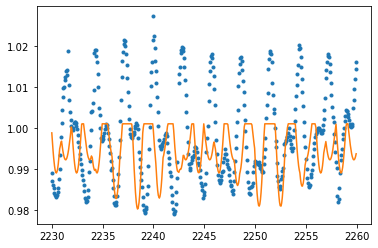

In [17]:
plt.plot(t1, f1, '.')
plt.plot(t1, m)

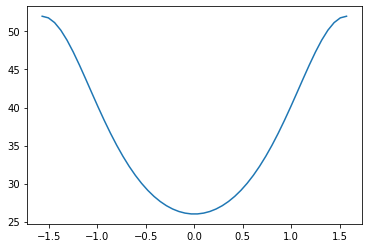

In [18]:
x = np.linspace(0, np.pi) - np.pi/2
shear = 0.5
plt.plot(x, 26 / (1 - shear * np.sin(x)**2))

Implement the same model with PyMC3 assuming: 

* there are 3 spots
* the lat, lon, radius of spots are allowed to vary
* contrast = 0.7
* flux residuals are Student t-distributed (robust against outliers)
* spot radii are small compared to stellar radius
* spots don't evolve significantly over this timescale

In [19]:
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner


e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

In [20]:
# n_spots = 4

# with pm.Model() as model1:

#     f0 = pm.Uniform("f0", lower=0, upper=1)
#     nu = pm.Uniform("nu", lower=1, upper=5)    
#     #slope = pm.Uniform("m", lower=-1, upper=1)
#     spot_model = 1 + f0 #+ slope * (t1 - t1.mean())
#     eq_period = pm.Uniform("P_eq", lower=5, upper=15)
#     shear = pm.Uniform("shear", lower=0.05, upper=0.6)
    
#     for spot_ind in range(n_spots):
#         rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.01, upper=0.3)
#         lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
#         latitude_cutoff = 10
#         lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
#         period = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)

#         spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
#         spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * (t1 - t1.mean()) - lon)
#         spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * (t1 - t1.mean()) - lon)
#         rsq = spot_position_x**2 + spot_position_y**2
#         contrast = 0.7
#         spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)
    
#     pm.StudentT("obs", mu=spot_model, nu=nu,
#                 sigma=e1_tt,
#                 observed=f1)
    
#     trace1 = sample_smc(10000, n_steps=2, random_seed=0, 
#                         cores=16, parallel=True, threshold=0.2)

Make a corner plot showing the posterior distributions for each parameter: 

In [21]:

# corner(pm.trace_to_dataframe(trace1));
# # plt.savefig('plots/corner_dr.png', bbox_inches='tight', dpi=100)

Plot the model evaluated at samples from the posterior distributions:

In [22]:
# samples = pm.trace_to_dataframe(trace1).values
# plt.plot(t1, f1, '.', color='k')

# for s in samples[np.random.randint(0, samples.shape[0], size=10)]:
#     f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
#     plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), color='r', alpha=0.5)
    
# plt.gca().set(xlabel='Time [d]', ylabel='Flux')
# # plt.savefig('plots/')
# plt.show()

In [23]:
# plt.plot(t1, f1 - numpy_model_seq(lat, lon, rspot, f0, per, shear), '.')

In [24]:
# plt.hist(samples[:, 3])

In [25]:
# import healpy as hp

# NSIDE = 2**10

# NPIX = hp.nside2npix(NSIDE)

# m = np.zeros(NPIX)

# samples = pm.trace_to_dataframe(trace1).values

# for rspot, lon, lat in np.median(samples[:, 4:], axis=0).reshape((n_spots, 3)):
#     print(lon, lat)
#     spot_vec = hp.ang2vec(lat, lon)
#     ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
#     m[ipix_spots] = 0.7

# cmap = plt.cm.Greys
# cmap.set_under('w')

# hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
#             max=1.0, notext=True, flip='geo')
# hp.graticule(color='silver')
# plt.show()

In [37]:
models = []
traces = []

min_spots = 5
max_spots = 7

for n_spots in range(min_spots, max_spots + 1):
    with pm.Model(name=n_spots) as model:

        f0 = pm.Uniform("f0", lower=0, upper=1)
        nu = pm.Uniform("nu", lower=1, upper=5)    
        spot_model = 1 + f0 
        eq_period = pm.Uniform("P_eq", lower=2, upper=4)
        shear = pm.Uniform("shear", lower=0.01, upper=0.6)

        for spot_ind in range(n_spots):
            rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.001, upper=0.4)
            lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
            lat = pm.Uniform(f"lat_{spot_ind}", lower=0, upper=np.pi)
            period = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)

            spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
            spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * (t1 - t1.mean()) - lon)
            spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * (t1 - t1.mean()) - lon)
            rsq = spot_position_x**2 + spot_position_y**2
            contrast = 0.7
            spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)

        pm.StudentT("obs", mu=spot_model, nu=nu,
                    sigma=e1_tt,
                    observed=f1)

        trace = sample_smc(100000, n_steps=2, random_seed=0, threshold=0.2,
                           cores=16, parallel=True)

#     corner(pm.trace_to_dataframe(trace));
#     plt.show()
    
    models.append(model)
    traces.append(trace)

Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
INFO:pymc3:Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:   2 Acce: 0.502
INFO:pymc3:Stage:   1 Beta: 0.001 Steps:   2 Acce: 0.502
Stage:   2 Beta: 0.004 Steps:   2 Acce: 0.367
INFO:pymc3:Stage:   2 Beta: 0.004 Steps:   2 Acce: 0.367
Stage:   3 Beta: 0.010 Steps:   2 Acce: 0.265
INFO:pymc3:Stage:   3 Beta: 0.010 Steps:   2 Acce: 0.265
Stage:   4 Beta: 0.017 Steps:   2 Acce: 0.155
INFO:pymc3:Stage:   4 Beta: 0.017 Steps:   2 Acce: 0.155
Stage:   5 Beta: 0.026 Steps:   2 Acce: 0.063
INFO:pymc3:Stage:   5 Beta: 0.026 Steps:   2 Acce: 0.063
Stage:   6 Beta: 0.037 Steps:   2 Acce: 0.033
INFO:pymc3:Stage:   6 Beta: 0.037 Steps:   2 Acce: 0.033
Stage:   7 Beta: 0.050 Steps:   2 Acce: 0.030
INFO:pymc3:Stage:   7 Beta: 0.050 Steps:   2 Acce: 0.030
Stage:   8 Beta: 0.060 Steps:   2 Acce: 0.055
INFO:pymc3:Stage:   8 Beta: 0.060 Steps:   2 Acce: 0.055
Stage:   9

In [38]:
# models[0].name = str(models[0].name)
# models[1].name = str(models[1].name)

In [39]:
loo = pm.compare({m: t for m, t in zip(models, traces)})
loo.index = [m.name for m in loo.index.values]

loo

//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO post

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
5,0,568.152,98.0752,0,0.770416,55.2637,0,True,log
6,1,529.096,77.1918,39.056,0.224883,57.1589,53.5031,True,log
7,2,445.92,68.7412,122.232,0.0047011,54.8666,52.7896,True,log


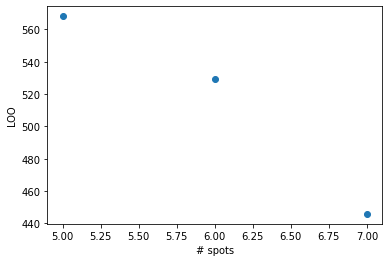

In [40]:
plt.plot(loo.index, loo.loo, 'o')
plt.xlabel('# spots')
plt.ylabel('LOO')
plt.savefig('plots/v1298_loo.png', bbox_inches='tight', dpi=150)

In [41]:
# lats = samples[:, 5::4]

# plt.hist(lats)
# plt.errorbar(lats.mean(axis=0), pers.mean(axis=0), xerr=lats.std(axis=0), yerr=pers.std(axis=0), fmt='o')

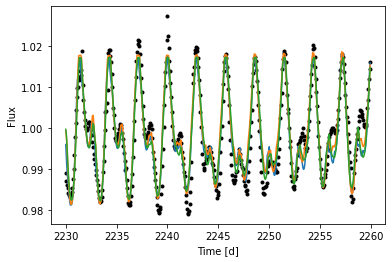

In [42]:
plt.plot(t1, f1, '.', color='k')

for i, trace in enumerate(traces): 
    samples = pm.trace_to_dataframe(trace).values

    for s in samples[np.random.randint(0, samples.shape[0], size=1)]:
        f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
        plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), color=f'C{i}', alpha=1)

plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.show()

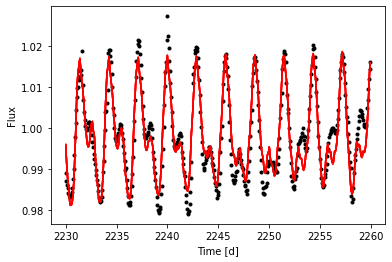

In [44]:
plt.plot(t1, f1, '.', color='k')

samples = pm.trace_to_dataframe(traces[0]).values

for s in samples[np.random.randint(0, samples.shape[0], size=50)]:
    f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
    plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), color='r', alpha=0.1)

plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.savefig('plots/v1298_fit.png', bbox_inches='tight', dpi=150)
plt.show()

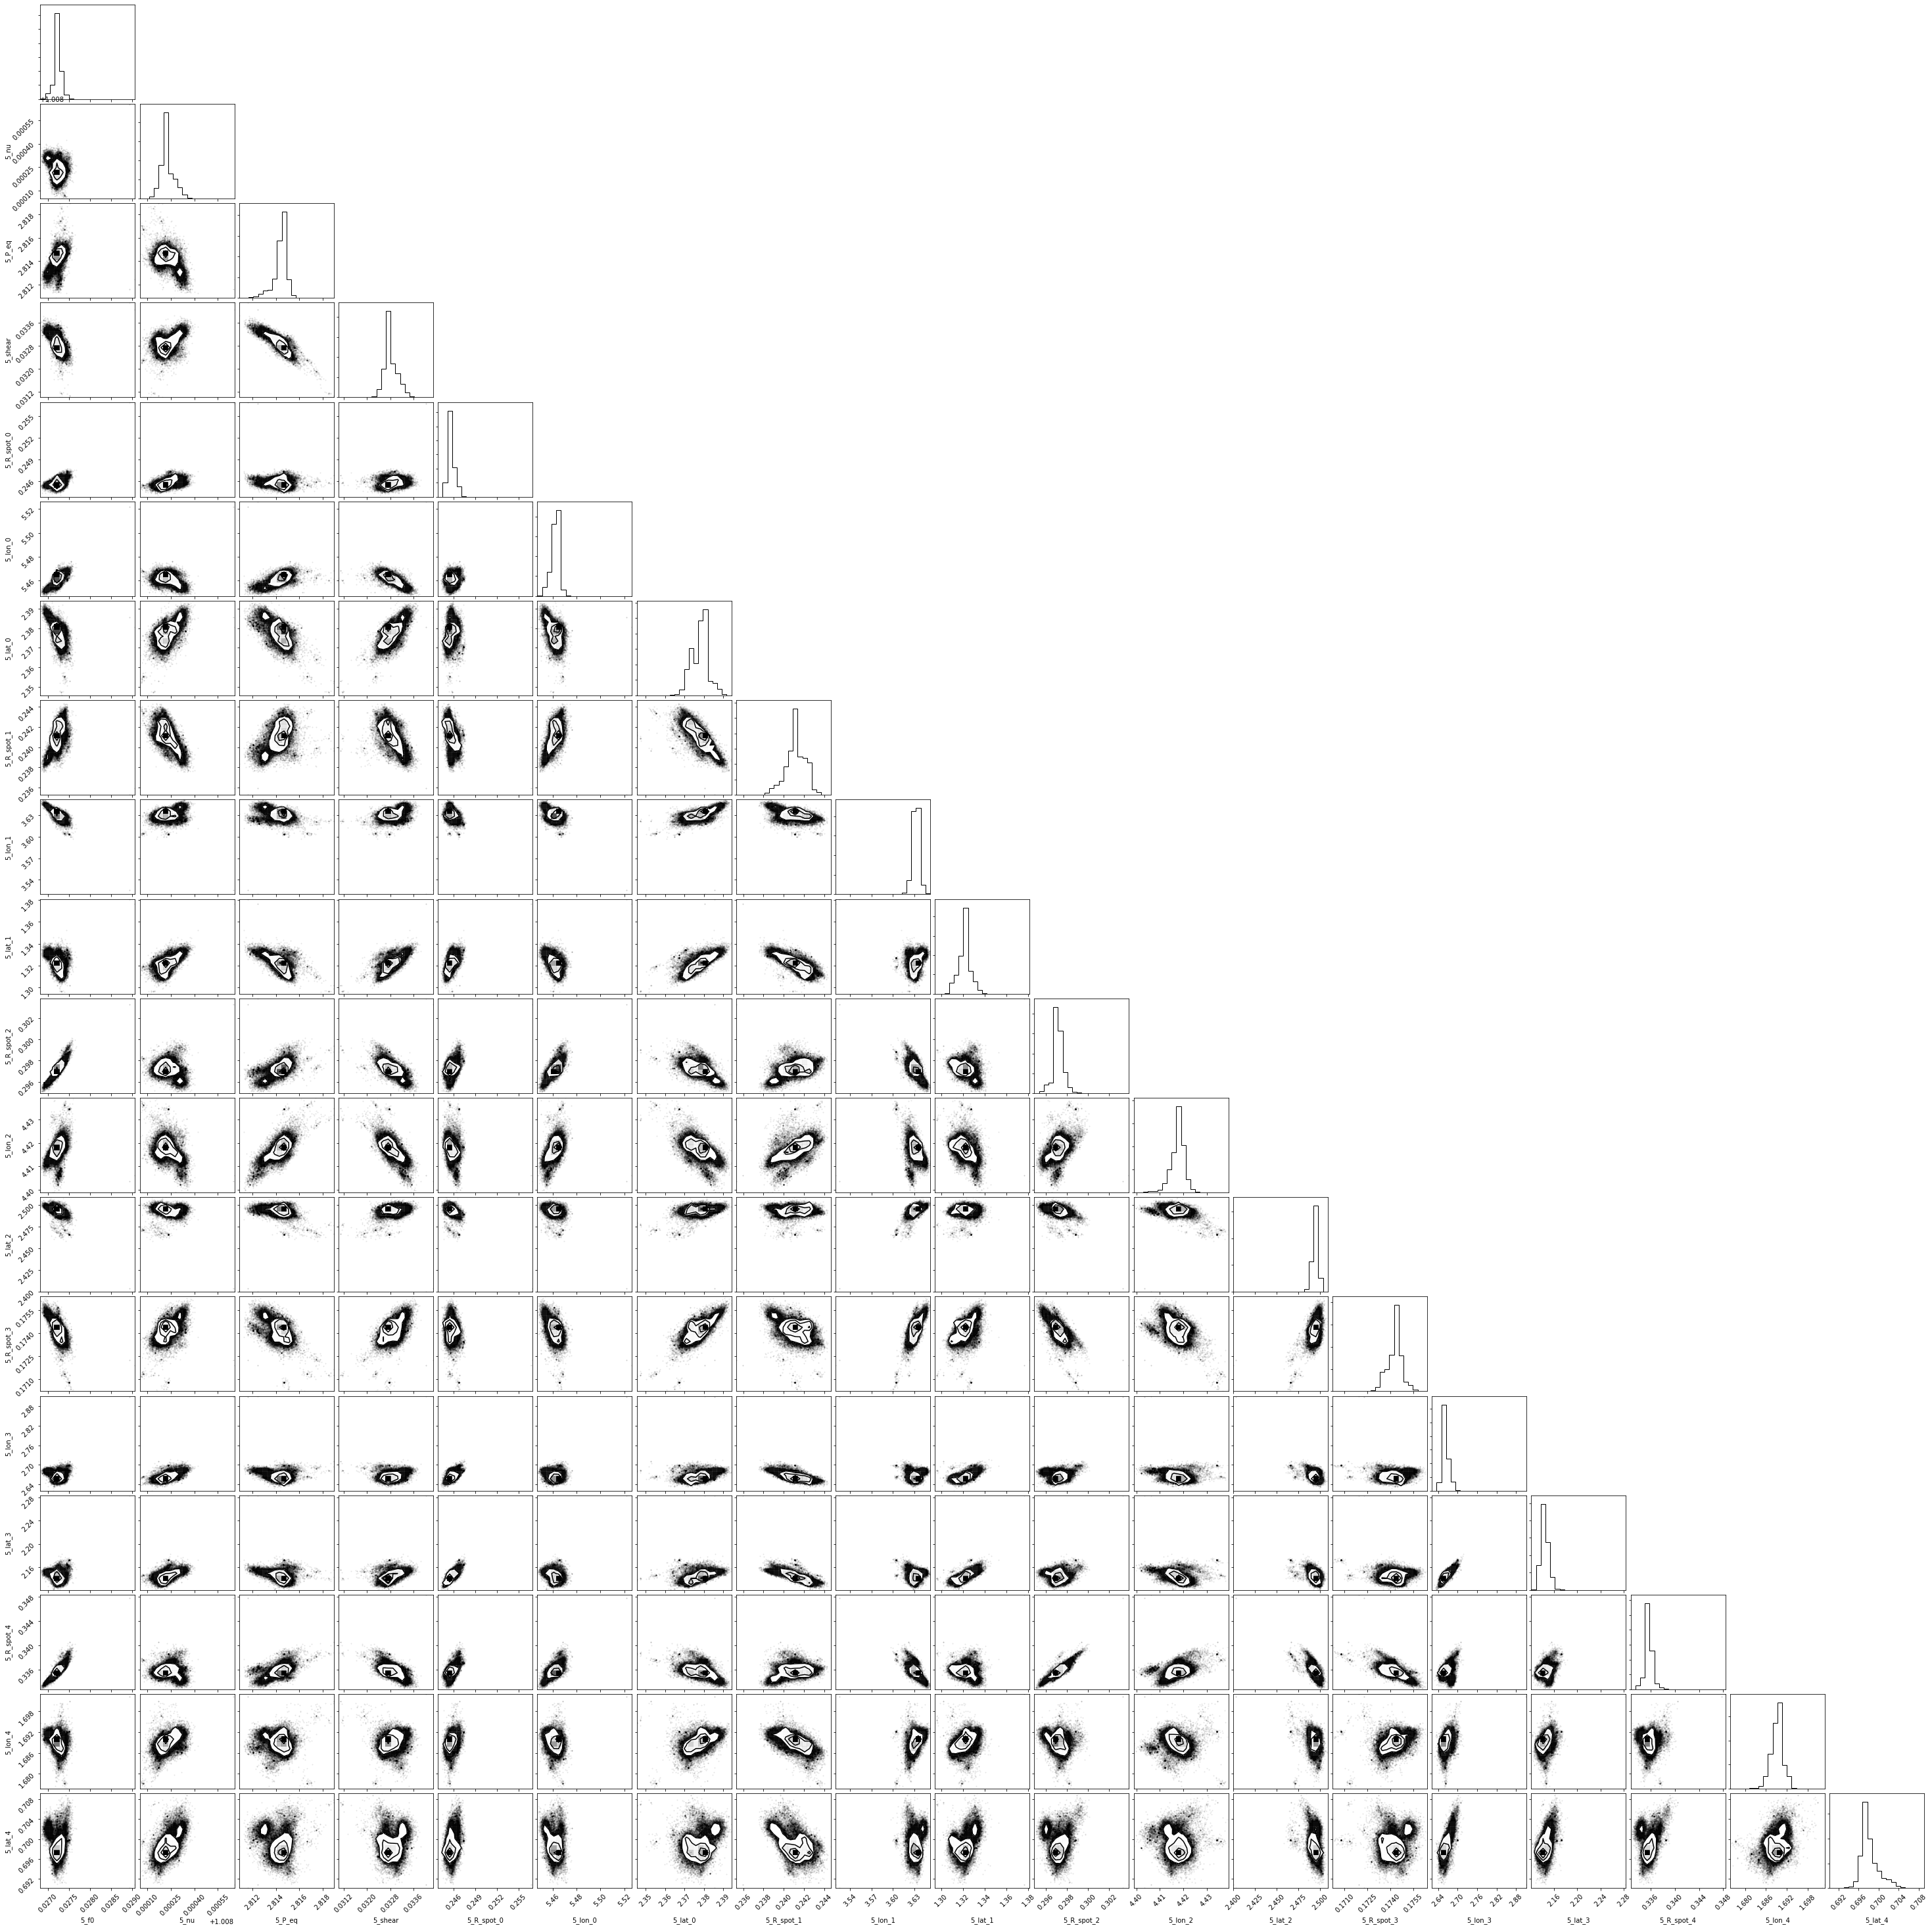

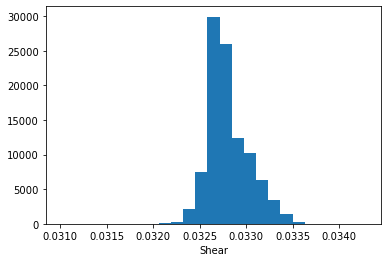

In [45]:
samples = pm.trace_to_dataframe(traces[0]).values

corner(samples, labels=[i for i in traces[0].varnames if not i.endswith('__')])
plt.savefig('plots/v1289_corner.png', bbox_inches='tight', dpi=100)
plt.show()

plt.hist(samples[:, 3], bins=25)
plt.xlabel('Shear')
plt.savefig('plots/v1298_shear.png', bbox_inches='tight')

5.46266132470473 2.378669558571644
3.6320805091418604 1.3217792813212392
4.41823003412683 2.4948121513297496
2.6610607167884552 2.1436118825958093
1.689347586934249 0.697676108941245
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


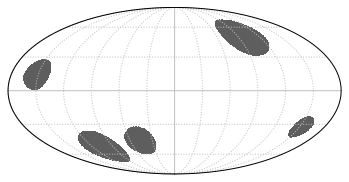

In [47]:
import healpy as hp

NSIDE = 2**8

NPIX = hp.nside2npix(NSIDE)

m = np.zeros(NPIX)

samples = pm.trace_to_dataframe(traces[0]).values

for rspot, lon, lat in np.median(samples[:, 4:], axis=0).reshape((5, 3)):
    print(lon, lat)
    spot_vec = hp.ang2vec(lat, lon)
    ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
    m[ipix_spots] = 0.7

cmap = plt.cm.Greys
cmap.set_under('w')

hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
            max=1.0, notext=True, flip='geo')
hp.graticule(color='silver')
plt.savefig('plots/v1298_map.png', bbox_inches='tight', dpi=150)
plt.show()

In [105]:
# np.median(samples[:, 4:], axis=0).reshape((6, 3))